# Spectrogram and MFCCs

In this post, you’ll get to explore it for yourself. Record your own audio files and explore how each step in the processing pipeline changes your audio signal and reveals features! This is the summary of lecture "Applications of TinyML" from edX.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, edX, Deep_Learning, Tensorflow, tinyML]
- image: 

In [10]:
from IPython.display import HTML, Audio
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from python_speech_features import mfcc
from matplotlib import cm
import pickle
import librosa

## Base knowledge

You saw that the raw analog audio signal is first transformed into a digital signal.

![adc](image/3-5-9-1.png)

You then saw how the digital signal in the **time domain** (time on the x-axis and amplitude on the y-axis) is transformed into the **frequency domain** (frequency on the x-axis and amplitude on the y-axis) through the use of a **fourier transform**. If you’d like to dive deeper into understanding how the fourier transform works we suggest you watch this fantastic [video](https://www.youtube.com/watch?v=spUNpyF58BY) on the 3Brown1Blue youtube channel.

Of course for the purposes of TinyML we need to worry about how we can compute this transformation efficiently -- both in the memory needed to store the program, and in the memory and latency needed for the computation. The solution is the use of an approximate **fast fourier transform (FFT)** of which there are multiple possible implementations. TensorflowLite Micro uses the [KISS_FFT library](https://github.com/mborgerding/kissfft), which includes more documentation about the design choices made by the library to be compact in memory on their GitHub page.

By applying the FFT through a sliding window procedure we can analyze the intensity (in color) of each of frequencies over time. This is a **spectrogram**.

![spectogram](image/3-5-9-2.png)

A spectrogram is a better input for a deep learning system than the standard input audio signal as we have already extracted the frequencies for the neural network and so it doesn’t need to learn how to do that on its own. Even visually, it is easier to see the difference between the “yes” and “no” spectrograms.

![spectogram2](image/3-5-9-3.png)

We then discussed how the human ear can tell low frequency signals apart easier than high frequency signals according to the Mel Scale. We can therefore create a **Mel Filter Bank** to take advantage of this phenomenon and group together larger clusters of higher frequency signals to provide more useful data to our machine learning algorithm. The output of this process is a **Mel Frequency Cepstral Coefficient (MFCC)**. For more information on how this works check out this [post](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

![spectogram3](image/3-5-9-4.png)

Of course there are many different ways you could solve this learning problem and it is likely that very large neural networks would perform quite well on this task without this preprocessing. However, for the case of TinyML this preprocessing is vital and drastically improves the final model performance without taking up a lot of memory or latency! 

## Load in the Audio Samples

In [39]:
fid = open('audio_files_sample.pkl', 'rb')
audio_files = pickle.load(fid)
audio_yes_loud = audio_files['audio_yes_loud']
sr_yes_loud = audio_files['sr_yes_loud']
audio_yes_quiet = audio_files['audio_yes_quiet']
sr_yes_quiet = audio_files['sr_yes_quiet']
audio_no_loud = audio_files['audio_no_loud']
sr_no_loud = audio_files['sr_no_loud']
audio_no_quiet = audio_files['audio_no_quiet']
sr_no_quiet = audio_files['sr_no_quiet']

You can hear the audio files you loaded by uncommenting and running the below

In [40]:
Audio(audio_yes_loud, rate=sr_yes_loud)

In [41]:
Audio(audio_yes_quiet, rate=sr_yes_quiet)

In [42]:
Audio(audio_no_loud, rate=sr_no_loud)

In [43]:
Audio(audio_no_quiet, rate=sr_no_quiet)

## Visualize the samples

### First as signals

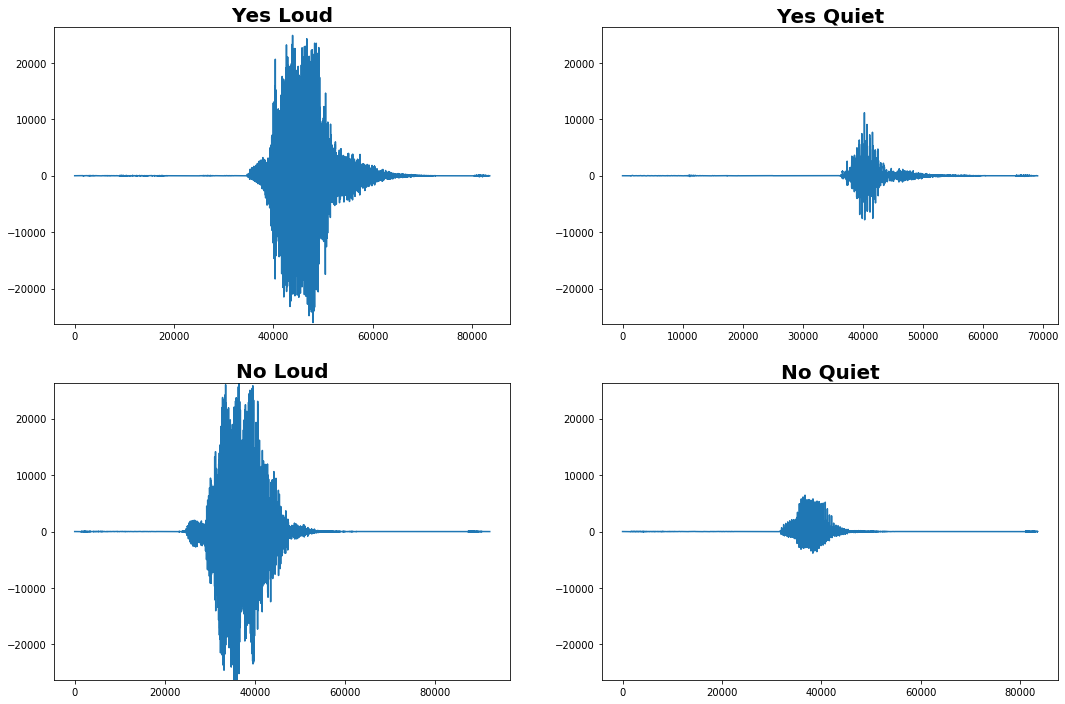

In [30]:
# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
max_val = int(np.max(np.append(np.append(np.append(audio_yes_loud,audio_yes_quiet),
                                         audio_no_loud),
                               audio_no_quiet)))
ax1.plot(audio_yes_loud)
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(-max_val, max_val)
ax2.plot(audio_yes_quiet)
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(-max_val, max_val)
ax3.plot(audio_no_loud)
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(-max_val, max_val)
ax4.plot(audio_no_quiet)
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(-max_val, max_val)
fig.set_size_inches(18,12)

### Then view the Fourier Transform of the Signal
Viewing the signal in the frequency domain.

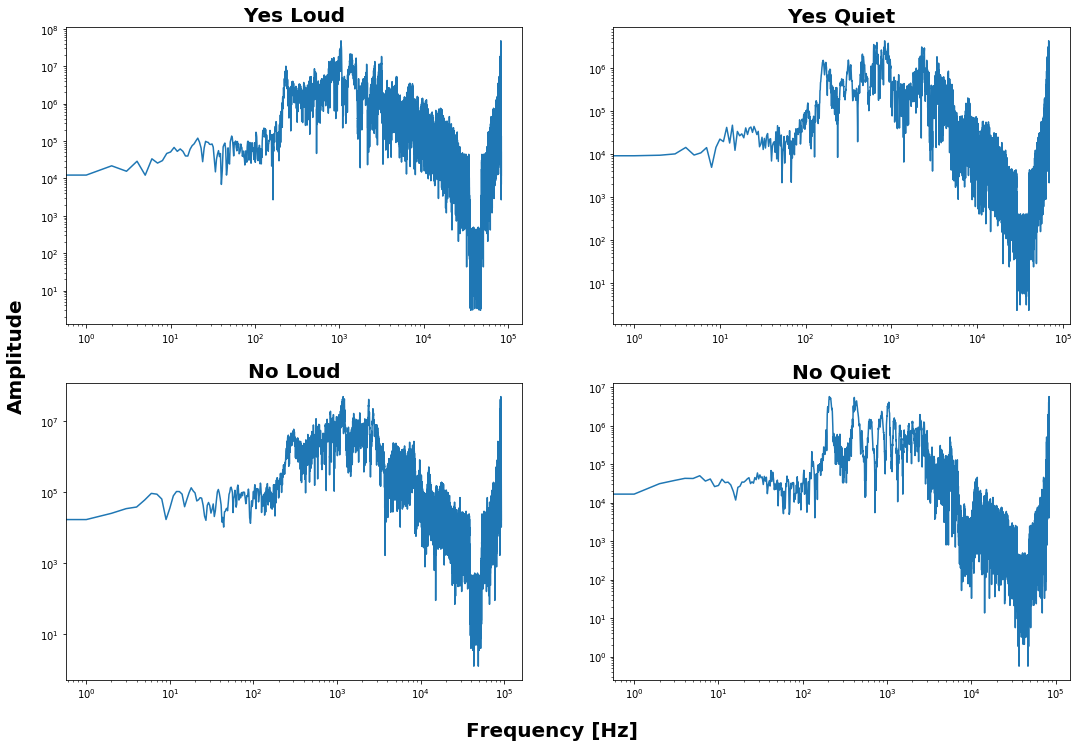

In [31]:
#Adapted from https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform
# compute the FFT and take the single-sided spectrum only and remove imaginary part
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ft_audio_yes_loud = np.abs(2*np.fft.fft(audio_yes_loud))
ft_audio_yes_quiet = np.abs(2*np.fft.fft(audio_yes_quiet))
ft_audio_no_loud = np.abs(2*np.fft.fft(audio_no_loud))
ft_audio_no_quiet = np.abs(2*np.fft.fft(audio_no_quiet))

# Plot the figure
ax1.plot(ft_audio_yes_loud)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.plot(ft_audio_yes_quiet)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.plot(ft_audio_no_loud)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.plot(ft_audio_no_quiet)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Frequency [Hz]', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Amplitude', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

### Then as spectrograms
Can you see how spectrograms can help machine learning models better differentiate between audio samples?

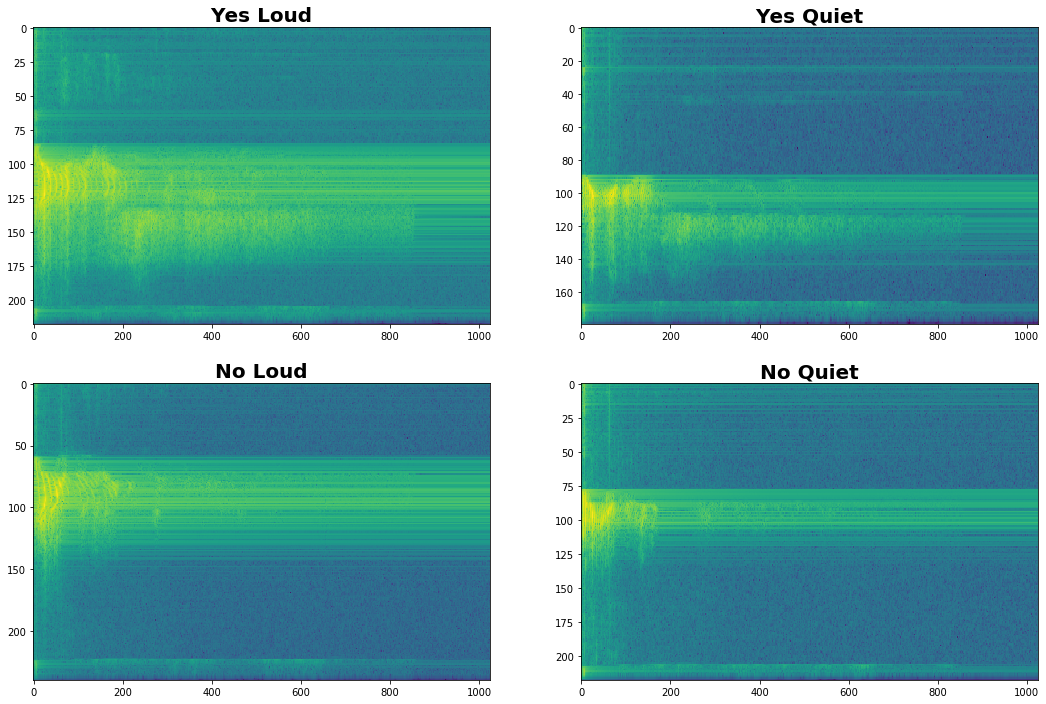

In [32]:
# Convert to spectrogram and display
# adapted from https://aruno14.medium.com/comparaison-of-audio-representation-in-tensorflow-b6c33a83d77f
spectrogram_yes_loud = tfio.experimental.audio.spectrogram(audio_yes_loud/1.0, 
                                                           nfft=2048, 
                                                           window=len(audio_yes_loud), 
                                                           stride=int(sr_yes_loud * 0.008))
spectrogram_yes_quiet = tfio.experimental.audio.spectrogram(audio_yes_quiet/1.0, 
                                                            nfft=2048, 
                                                            window=len(audio_yes_quiet), 
                                                            stride=int(sr_yes_quiet * 0.008))
spectrogram_no_loud = tfio.experimental.audio.spectrogram(audio_no_loud/1.0, 
                                                          nfft=2048, 
                                                          window=len(audio_no_loud), 
                                                          stride=int(sr_no_loud * 0.008))
spectrogram_no_quiet = tfio.experimental.audio.spectrogram(audio_no_quiet/1.0, 
                                                           nfft=2048, 
                                                           window=len(audio_no_quiet), 
                                                           stride=int(sr_no_quiet * 0.008))

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(tf.math.log(spectrogram_yes_loud).numpy(), aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.imshow(tf.math.log(spectrogram_yes_quiet).numpy(), aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.imshow(tf.math.log(spectrogram_no_loud).numpy(), aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.imshow(tf.math.log(spectrogram_no_quiet).numpy(), aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)

### Then as MFCCs
Using the Mel Scale to better associate the features to human hearing!

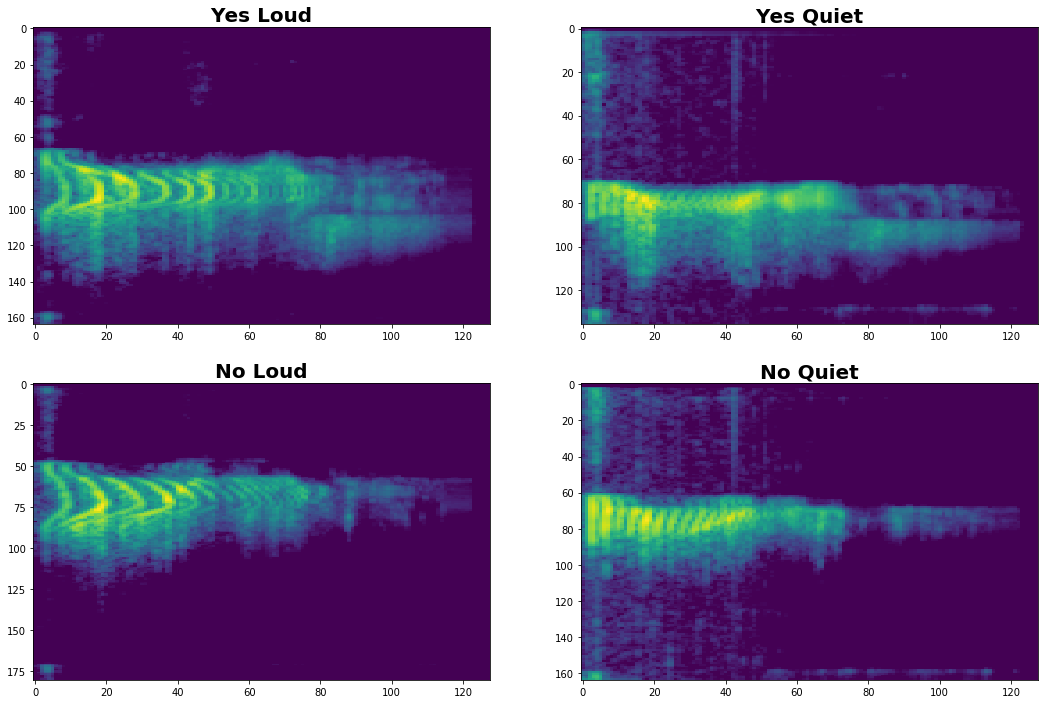

In [33]:
# Convert to MFCC using the Mel Scale
# adapted from: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
mfcc_yes_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_yes_loud), sr=sr_yes_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_yes_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_yes_quiet), sr=sr_yes_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_no_loud), sr=sr_no_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_no_quiet), sr=sr_no_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(np.swapaxes(mfcc_yes_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.imshow(np.swapaxes(mfcc_yes_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(ax2.get_ylim()[::-1])
ax3.imshow(np.swapaxes(mfcc_no_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(ax3.get_ylim()[::-1])
ax4.imshow(np.swapaxes(mfcc_no_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(ax4.get_ylim()[::-1])
fig.set_size_inches(18,12)